In [2]:
# Kết nối Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
from google.colab import files
files.upload()  # Chọn và tải lên kaggle.json từ máy bạn


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"phclhong23","key":"0d30703be3655f7396025654db277c15"}'}

In [3]:
# Tạo thư mục .kaggle và chuyển file vào đó
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Cài kaggle CLI nếu chưa có
!pip install -q kaggle

# Tải Flickr8k Dataset
!kaggle datasets download -d adityajn105/flickr8k

# Giải nén file ZIP
!unzip -q flickr8k.zip -d /content/flickr8k


Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0


In [4]:
# Tạo thư mục trong Drive
!mkdir -p /content/drive/MyDrive/Flickr8k

# Sao chép dữ liệu vào Drive
!cp -r /content/flickr8k/* /content/drive/MyDrive/Flickr8k/

In [5]:
# Image Captioning with Flickr8k Dataset on Google Colab

# ---------------------------
# 1. Import Libraries
# ---------------------------
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import re
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
from tqdm import tqdm_notebook
from collections import Counter

In [6]:
# 2. Define Paths

images_directory = '/content/drive/MyDrive/Flickr8k/Images'

captions_path = '/content/drive/MyDrive/Flickr8k/captions.txt'

In [7]:
# 3. Load and Preprocess Captions
def load_captions(file_path):
    with open(file_path, 'r') as f:
        captions = f.readlines()
        # Lowercasing  the captions
        captions = [caption.lower() for caption in captions[1:]]
    return captions

def tokenize_captions(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    return tokenizer

# Loading the captions from the dataset
captions = load_captions(captions_path)
captions[:15:3]

['1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playhouse .\n',
 '1001773457_577c3a7d70.jpg,a black dog and a tri-colored dog playing with each other on the road .\n',
 '1001773457_577c3a7d70.jpg,two dogs on pavement moving toward each other .\n',
 '1002674143_1b742ab4b8.jpg,a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .\n']

In [8]:
def clean_text(text):
    # Removing punctuation marks
    text = re.sub(r'[^\w\s]', '', text)

    # Removing numbers
    text = re.sub(r'\d+', '', text)

    # Removing extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Cleaning the captions
cleaned_captions = [clean_text(caption.split(',')[1]) for caption in captions]
cleaned_captions[:15:2]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a little girl climbing into a wooden playhouse',
 'a little girl in a pink dress going into a wooden cabin',
 'a black dog and a tricolored dog playing with each other on the road',
 'two dogs of different breeds looking at each other on the road',
 'a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl',
 'a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it',
 'young girl with pigtails painting outside in the grass']

In [9]:
# Image ID + \t + Caption
captions_IDs = []
for i in range(len(cleaned_captions)):
    #  Adding 'start' word and 'end' word to the captions
    item = captions[i].split(',')[0]+'\t'+'start '+cleaned_captions[i]+' end\n'
    captions_IDs.append(item)

captions_IDs[:20:3], len(captions_IDs)

(['1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
  '1000268201_693b08cb0e.jpg\tstart a little girl climbing the stairs to her playhouse end\n',
  '1001773457_577c3a7d70.jpg\tstart a black dog and a tricolored dog playing with each other on the road end\n',
  '1001773457_577c3a7d70.jpg\tstart two dogs on pavement moving toward each other end\n',
  '1002674143_1b742ab4b8.jpg\tstart a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it end\n',
  '1003163366_44323f5815.jpg\tstart a man lays on a bench while his dog sits by him end\n',
  '1003163366_44323f5815.jpg\tstart a shirtless man lies on a park bench with his dog end\n'],
 40455)

In [10]:
# 4. Tokenize Captions
tokenizer = tokenize_captions(cleaned_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8586

In [11]:
# 5. Split Dataset
# Storing all image IDs
all_image_ids = os.listdir(images_directory)

# Splitting image IDs
train_image_ids, val_image_ids = train_test_split(all_image_ids, test_size=0.15, random_state=42)
val_image_ids, test_image_ids = train_test_split(val_image_ids, test_size=0.1, random_state=42)

train_captions, val_captions, test_captions = [], [], []
for caption in captions_IDs:
    image_id, _ = caption.split('\t')

    if image_id in train_image_ids:
        train_captions.append(caption)

    elif image_id in val_image_ids:
        val_captions.append(caption)

    elif image_id in test_image_ids:
        test_captions.append(caption)

    else:
        print('Unknown image ID !')

train_captions[0], val_captions[0], test_captions[0], len(train_captions)/5, len(val_captions)/5, len(test_captions)/5

('1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
 '1022454428_b6b660a67b.jpg\tstart a couple and an infant end\n',
 '1042590306_95dea0916c.jpg\tstart a man and woman pose for the camera while another man looks on end\n',
 6877.0,
 1092.0,
 122.0)

In [12]:
# --- Tiền xử lý ảnh để phù hợp với mô hình InceptionV3 ---
def preprocess_image(image_path):
    # Đọc ảnh và thay đổi kích thước về 299x299 pixel (đúng yêu cầu của InceptionV3)
    img = load_img(image_path, target_size=(299, 299))
    # Chuyển ảnh sang dạng mảng numpy
    img = img_to_array(img)
    # Thêm một chiều batch để phù hợp với đầu vào mô hình (1, 299, 299, 3)
    img = np.expand_dims(img, axis=0)
    # Chuẩn hóa dữ liệu theo cách mà InceptionV3 yêu cầu
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

# --- Trích xuất đặc trưng từ ảnh bằng mô hình InceptionV3 ---
def extract_image_features(model, image_path):
    # Tiền xử lý ảnh
    img = preprocess_image(image_path)
    # Trích xuất đặc trưng ảnh bằng mô hình đã huấn luyện trước
    features = model.predict(img, verbose=0)
    return features

# --- Tải mô hình InceptionV3 đã huấn luyện trên ImageNet ---
# Sử dụng trọng số đã huấn luyện sẵn (weights='imagenet'), và đầu vào 299x299x3
inception_v3_model = InceptionV3(weights='imagenet', input_shape=(299, 299, 3))

# Loại bỏ lớp cuối cùng (softmax phân loại 1000 lớp) vì ta chỉ cần đặc trưng, không cần phân loại
inception_v3_model.layers.pop()

# Tạo mô hình mới có đầu ra là lớp áp chót (trước lớp softmax)
inception_v3_model = Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.layers[-2].output)


96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Trích xuất đặc trưng

In [13]:
# Tạo 3 dictionary để lưu đặc trưng ảnh tương ứng với các tập huấn luyện, kiểm tra và kiểm định
train_image_features, val_image_features, test_image_features = {}, {}, {}

# Tạo thanh tiến trình để theo dõi quá trình xử lý ảnh
pbar = tqdm_notebook(total=len(all_image_ids), position=0, leave=True, colour='green')

# Duyệt qua từng dòng trong danh sách ID ảnh (all_image_ids chứa các dòng như: '12345.jpg\t<caption>')
for caption in all_image_ids:
    image_id = caption.split('\t')[0]
    image_path = os.path.join(images_directory, image_id)

    try:
        image_features = extract_image_features(inception_v3_model, image_path)

        if image_id in train_image_ids:
            train_image_features[image_id] = image_features.flatten()
            pbar.update(1)
        elif image_id in val_image_ids:
            val_image_features[image_id] = image_features.flatten()
            pbar.update(1)
        elif image_id in test_image_ids:
            test_image_features[image_id] = image_features.flatten()
            pbar.update(1)
        else:
            print(f"⚠️ Unknown image ID: {image_id}")

    except Exception as e:
        print(f"❌ Lỗi với ảnh {image_id}: {e}")


# Đóng thanh tiến trình sau khi hoàn thành
pbar.close()



  0%|          | 0/8091 [00:00<?, ?it/s]

In [14]:
import pickle
import os

# Đường dẫn thư mục lưu file
save_dir = "/content/drive/MyDrive/Deeplearning Hoc sau/CUOI KI"

# Tạo thư mục nếu chưa tồn tại
os.makedirs(save_dir, exist_ok=True)

# Lưu từng dictionary dưới dạng .pkl
with open(os.path.join(save_dir, "train_image_features.pkl"), "wb") as f:
    pickle.dump(train_image_features, f)

with open(os.path.join(save_dir, "val_image_features.pkl"), "wb") as f:
    pickle.dump(val_image_features, f)

with open(os.path.join(save_dir, "test_image_features.pkl"), "wb") as f:
    pickle.dump(test_image_features, f)

print("✅ Đã lưu trích xuất đặc trưng vào Google Drive.")


✅ Đã lưu trích xuất đặc trưng vào Google Drive.


In [ ]:
import pickle
import os

# Đường dẫn thư mục chứa các file .pkl
load_dir = "/content/drive/MyDrive/Deeplearning Hoc sau/CUOI KI"

# Load từng dictionary từ file
with open(os.path.join(load_dir, "train_image_features.pkl"), "rb") as f:
    train_image_features = pickle.load(f)

with open(os.path.join(load_dir, "val_image_features.pkl"), "rb") as f:
    val_image_features = pickle.load(f)

with open(os.path.join(load_dir, "test_image_features.pkl"), "rb") as f:
    test_image_features = pickle.load(f)

print("✅ Đã load đặc trưng ảnh từ Google Drive thành công.")


In [18]:
# Generator tạo dữ liệu huấn luyện/validation theo batch từ các caption và đặc trưng ảnh
def data_generator(captions, image_features, tokenizer, max_caption_length, batch_size):
    total_captions = len(captions)
    image_keys = list(image_features.keys())

    while True:
        np.random.shuffle(image_keys)  # Trộn ảnh mỗi epoch
        for idx in range(0, total_captions, batch_size):
            batch_captions = captions[idx:idx + batch_size]
            X_images, X_captions, y = [], [], []

            for entry in batch_captions:
                image_id, caption_text = entry.split('\t')
                tokens = tokenizer.texts_to_sequences([caption_text.strip()])[0]

                for i in range(1, len(tokens)):
                    in_seq = tokens[:i]
                    out_seq = tokens[i]

                    padded_input = pad_sequences([in_seq], maxlen=max_caption_length, padding='post')[0]
                    categorical_output = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X_images.append(image_features[image_id])
                    X_captions.append(padded_input)
                    y.append(categorical_output)

            yield (np.array(X_images), np.array(X_captions)), np.array(y)


# Thiết lập tham số
max_caption_length = max(len(c.split()) for c in cleaned_captions) + 1
cnn_output_dim = inception_v3_model.output_shape[1]
batch_size_train = 270
batch_size_val = 150

# Khởi tạo generator cho tập huấn luyện và validation
train_data_generator = data_generator(train_captions, train_image_features, tokenizer, max_caption_length, batch_size_train)
val_data_generator = data_generator(val_captions, val_image_features, tokenizer, max_caption_length, batch_size_val)


In [19]:
# Kiểm tra kích thước batch mẫu từ train generator
train_batch = next(train_data_generator)
print("Training sample batch shapes:")
print(f"  X_images:    {train_batch[0][0].shape}")
print(f"  X_captions:  {train_batch[0][1].shape}")
print(f"  y:           {train_batch[1].shape}")

print("=" * 30)

# Kiểm tra kích thước batch mẫu từ validation generator
val_batch = next(val_data_generator)
print("Validation sample batch shapes:")
print(f"  X_images:    {val_batch[0][0].shape}")
print(f"  X_captions:  {val_batch[0][1].shape}")
print(f"  y:           {val_batch[1].shape}")


Training sample batch shapes:
  X_images:    (3258, 2048)
  X_captions:  (3258, 34)
  y:           (3258, 8586)
Validation sample batch shapes:
  X_images:    (1817, 2048)
  X_captions:  (1817, 34)
  y:           (1817, 8586)


In [21]:
#test
def build_model(vocab_size, max_caption_length, cnn_output_dim):
    # --- ENCODER ---
    input_image = Input(shape=(cnn_output_dim,), name='Features_Input')
    x_img = BatchNormalization()(input_image)
    x_img = Dense(256, activation='relu')(x_img)
    x_img = BatchNormalization()(x_img)

    # --- DECODER ---
    input_caption = Input(shape=(max_caption_length,), name='Sequence_Input')
    x_txt = Embedding(input_dim=vocab_size, output_dim=256, mask_zero=True)(input_caption)
    x_txt = LSTM(256)(x_txt)

    # --- COMBINING ---
    merged = add([x_img, x_txt])
    x = Dense(256, activation='relu')(merged)
    output = Dense(vocab_size, activation='softmax', name='Output_Layer')(x)

    # Model definition
    model = Model(inputs=[input_image, input_caption], outputs=output, name='Image_Captioning')
    return model

# Khởi tạo mô hình
caption_model = build_model(vocab_size, max_caption_length, cnn_output_dim)

# Biên dịch với optimizer và loss
optimizer = Adam(learning_rate=0.01, clipnorm=1.0)
caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

# Tổng quan mô hình
caption_model.summary()


Model: "Image_Captioning"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Features_Input      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ Features_Input[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Sequence_Input      │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  2,198,016 │ Sequence_Input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 34)        │          0 │ Sequence_Input[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ batch_normalizat… │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Layer        │ (None, 8586)      │  2,206,602 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,529,482 (21.09 MB)

 Trainable params: 5,524,874 (21.08 MB)

 Non-trainable params: 4,608 (18.00 KB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.6))


# Learning Rate Scheduler
lr_schedule = LearningRateScheduler(lr_scheduler)

history = caption_model.fit(train_data_generator, steps_per_epoch=len(train_captions) // batch_size_train,
                        validation_data=val_data_generator, validation_steps=len(val_captions) // batch_size_val,
                        epochs=25, callbacks=[early_stopping, lr_schedule])

Epoch 1/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 84s 615ms/step - loss: 5.1894 - val_loss: 3.7230 - learning_rate: 0.0055
Epoch 2/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 83s 659ms/step - loss: 3.3483 - val_loss: 3.3778 - learning_rate: 0.0030
Epoch 3/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 78s 617ms/step - loss: 2.9466 - val_loss: 3.2683 - learning_rate: 0.0017
Epoch 4/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 81s 645ms/step - loss: 2.7358 - val_loss: 3.2337 - learning_rate: 9.0718e-04
Epoch 5/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 77s 609ms/step - loss: 2.5979 - val_loss: 3.2277 - learning_rate: 4.9787e-04
Epoch 6/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 77s 606ms/step - loss: 2.5171 - val_loss: 3.2202 - learning_rate: 2.7324e-04
Epoch 7/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 76s 603ms/step - loss: 2.4658 - val_loss: 3.2197 - learning_rate: 1.4996e-04
Epoch 8/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 81s 640ms/step - loss: 2.4362 - val_loss: 3.2176 - learning_rate: 8.2297e-05
Epoch 9/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 77s 609ms/step - loss: 2.4178 - val_

In [22]:
# Khởi tạo EarlyStopping để dừng sớm nếu val_loss không cải thiện
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Định nghĩa hàm điều chỉnh learning rate theo từng epoch
def lr_scheduler(epoch, lr):
    decay = tf.math.exp(-0.6)
    return float(lr * decay)

# Callback cho lịch trình learning rate
lr_schedule = LearningRateScheduler(lr_scheduler)

# Huấn luyện mô hình với generator và callback
history = caption_model.fit(
    train_data_generator,
    steps_per_epoch=len(train_captions) // batch_size_train,
    validation_data=val_data_generator,
    validation_steps=len(val_captions) // batch_size_val,
    epochs=25,
    callbacks=[early_stopping, lr_schedule]
)


Epoch 1/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 86s 621ms/step - loss: 5.1953 - val_loss: 3.7117 - learning_rate: 0.0055
Epoch 2/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 79s 628ms/step - loss: 3.3689 - val_loss: 3.3344 - learning_rate: 0.0030
Epoch 3/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 77s 608ms/step - loss: 2.9586 - val_loss: 3.2390 - learning_rate: 0.0017
Epoch 4/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 75s 595ms/step - loss: 2.7402 - val_loss: 3.2182 - learning_rate: 9.0718e-04
Epoch 5/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 77s 608ms/step - loss: 2.6048 - val_loss: 3.2170 - learning_rate: 4.9787e-04
Epoch 6/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 81s 645ms/step - loss: 2.5235 - val_loss: 3.2264 - learning_rate: 2.7324e-04
Epoch 7/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 75s 591ms/step - loss: 2.4717 - val_loss: 3.2328 - learning_rate: 1.4996e-04
Epoch 8/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 75s 591ms/step - loss: 2.4416 - val_loss: 3.2285 - learning_rate: 8.2297e-05


In [23]:
# Lưu mô hình
caption_model.save('/content/drive/MyDrive/Deeplearning Hoc sau/CUOI KI/image_caption_model.keras')


In [24]:
def generate_caption(model, tokenizer, image_feature, max_length):
    in_text = 'start'

    for _ in range(max_length):
        # Chuyển caption hiện tại thành chuỗi số và pad
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

        # Dự đoán từ tiếp theo
        yhat = model.predict([image_feature, sequence], verbose=0)
        predicted_id = np.argmax(yhat)
        word = tokenizer.index_word.get(predicted_id)

        # Dừng nếu không có từ hoặc gặp 'end'
        if word is None or word == 'end':
            break

        # Nối từ dự đoán vào chuỗi caption
        in_text += ' ' + word

    # Trả về kết quả không gồm 'start'
    return in_text.replace('start ', '').strip()


In [25]:
def visualize_test_predictions(model, test_image_ids, test_image_features, tokenizer, max_length, num_images=5):
    # Thiết lập kích thước hình vẽ
    fig = plt.figure(figsize=(15, 20))

    # Lấy một số ảnh mẫu từ tập test
    selected_images = test_image_ids[:num_images]

    for idx, image_id in enumerate(selected_images):
        # Đường dẫn ảnh
        image_path = os.path.join(images_directory, image_id)

        # Lấy đặc trưng ảnh và dự đoán caption
        image_feature = np.expand_dims(test_image_features[image_id], axis=0)
        predicted_caption = generate_caption(model, tokenizer, image_feature, max_length)

        # Hiển thị ảnh
        img = load_img(image_path, target_size=(299, 299))
        ax = fig.add_subplot(num_images, 1, idx + 1)
        ax.imshow(img)
        ax.set_title(f"Predicted Caption:\n{predicted_caption}", fontsize=14)
        ax.axis('off')  # Ẩn trục cho gọn

    plt.tight_layout()
    plt.show()


In [26]:
def caption_from_drive_image(model, tokenizer, max_length, image_path):
    # Tiền xử lý ảnh đầu vào
    processed_img = preprocess_image(image_path)

    # Trích xuất đặc trưng ảnh từ mô hình InceptionV3
    features = inception_v3_model.predict(processed_img, verbose=0)

    # Tạo chú thích từ đặc trưng ảnh
    caption = generate_caption(model, tokenizer, features, max_length)

    # Hiển thị ảnh và caption
    plt.figure(figsize=(6, 6))
    image_display = load_img(image_path, target_size=(299, 299))
    plt.imshow(image_display)
    plt.axis('off')
    plt.title(f"Predicted Caption:\n{caption}", fontsize=14)
    plt.show()


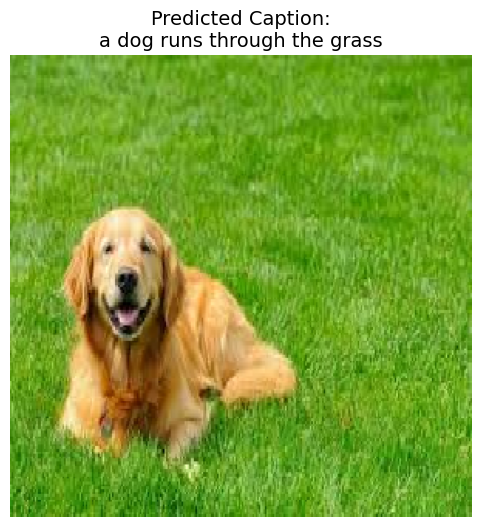

In [29]:

image_path = '/content/drive/MyDrive/Deeplearning Hoc sau/CUOI KI/dog.jpeg'
caption_from_drive_image(caption_model, tokenizer, max_caption_length, image_path)

**load model**

In [30]:
from tensorflow.keras.models import load_model

caption_model = load_model('/content/drive/MyDrive/Deeplearning Hoc sau/CUOI KI/image_caption_model.keras')



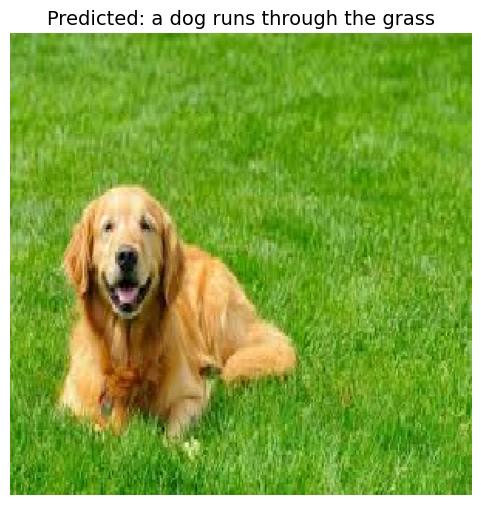

Ground truth: dog and grass


In [38]:
image_path = '/content/drive/MyDrive/Deeplearning Hoc sau/CUOI KI/dog.jpeg'
caption_from_drive_image(caption_model, tokenizer, max_caption_length, image_path)
print("Ground truth: dog and grass")


In [39]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def evaluate_bleu_score(model, test_captions, test_image_features, tokenizer, max_length, num_samples=100):
    smoothie = SmoothingFunction().method4
    scores = []

    for i, caption in enumerate(test_captions[:num_samples]):
        image_id, true_caption = caption.split('\t')
        image_feature = np.expand_dims(test_image_features[image_id], axis=0)
        predicted = generate_caption(model, tokenizer, image_feature, max_length)

        reference = [true_caption.strip().split()]
        candidate = predicted.split()
        score = sentence_bleu(reference, candidate, smoothing_function=smoothie)
        scores.append(score)

    avg_score = np.mean(scores)
    print(f"Average BLEU score on {num_samples} test samples: {avg_score:.4f}")


In [40]:
evaluate_bleu_score(caption_model, test_captions, test_image_features, tokenizer, max_caption_length)


Average BLEU score on 100 test samples: 0.0536
